# Inline Profiler

Inline Profiler is designed to make better profiling experience than NsightSystem in some aspect and focusing on specific important modules, finally let developer know whether the optimization is really scaling.

Currently NsightSystem has several disadvatanges when profiling HugeCTR:

1. It introduce some overheads.
2. There are many blanks in timeline view and too many kernels. It makes hard for developers to have a clear vision on things they are interested.

So, we come up with this inline profiler, it:

1. Try to reduce overhead as much as possible by running profiling on only 1 kernel per iteration with CudaEvent.
2. Let user define what they are interested and try to provide a more clear vision on how things are optimized.
3. Introduce zero overhead for the code in the formal release version.

## Usage

1. Add `-DENABLE_PROFILING=ON` when pass args to Cmake. And then do the normal `make` process.

2. In `tools/profiler/schedule.py`, there defines all the optional events you may want to profile in each layer. You can just comment out some events you are not inerested in the `dlrm_perf_schedule`. If you want to add new event, please contact Randy Wang or Daniel Abel. It would be better to insert the profile macro `PROFILE_RECORD(label, stream, device_id)` by the profiler developer. We will try to meet developers' need and add necessary events.

3. `cd HugeCTR_PROJECT_ROOT` and `python3 tools/profiler/schedule.py`. This will generate a `prof.schedule` file under the project root. It is used to instruct profiler to schedule profiling.

4. Then just train the hugectr like normal, for example `NCCL_LAUNCH_MODE=PARALLEL ./build//bin/huge_ctr --train ./experiment/dlrm_fp16_16k.json`. The profiler will collect data during training and prof only 1 kernel per iteration and the program will terminate after profiling complete.

5. A file named 'prof.json' will appear in the project root. It records the kernel execution order, stream, device, prof time, etc.


In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 1000px; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import sys
import os
from datetime import datetime
from shutil import copy

from IPython.display import display

sys.path.append(os.path.join(os.path.abspath(''), '..', '..'))

from tools.profiler import generate_schedule, parse_result, print_result

dlrm_perf_schedule = {
    # interested event name
    'BottomMLP.fc1': {
        'forward_events': [
  #          'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
   #         'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
 #           'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
  #          'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'BottomMLP.fc2': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'BottomMLP.fc3': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'sparse_embedding1': {
        'forward_events': [
            'localized_slot_sparse_embedding_one_hot.forward.mapping_and_fuse'
        ],
        'backward_events': []
    },
    'interaction1': {
        'forward_events': [],
        'backward_events': [] 
    },
    'TopMLP.fc4': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'TopMLP.fc5': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'TopMLP.fc6': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'TopMLP.fc7': {
        'forward_events': [
            'fused_fully_connected.fprop',
            'fused_fully_connected.fprop.cublasGemmEx',
            'fused_fully_connected.fprop.add_bias_and_re_kernel',  
        ],
        'backward_events': [
            'fused_fully_connected.bprop',
            'fused_fully_connected.bprop.initialize_array',
            'fused_fully_connected.bprop.reverse_add_bias_and_re_kernel',
            'fused_fully_connected.bprop.convert_array',
            'fused_fully_connected.bprop.cublasGemmEx_1',
            'fused_fully_connected.bprop.cublasGemmEx_2'            
        ]
    },
    'TopMLP.fc8': {
        'forward_events': [],
        'backward_events': []
    },
}

In [2]:
working_dir = os.path.abspath('')
# some configs
slurm_nodes = 4
slurm_account = "mlperft-dlrm"
container_image = "gitlab-master.nvidia.com/dl/hugectr/hugectr:mlperf_multi-node_ib_nightly_ci.latest"
container_name = "inline_profiler_hugectr"
container_mounts="/lustre/fsr:/raid,/lustre/fsw/mlperft-dlrm/ruotongw/hugectr:/etc/workspace/home"
config_file = os.path.join(working_dir, '../../mlperf/configs/55296_8gpus.json')

profiling_dir = os.path.join(working_dir, 'test')
#profiling_dir = os.path.join(working_dir, datetime.now().strftime("%Y-%d%m-%H-%M-%S"))
os.makedirs(profiling_dir, exist_ok=True)
copy(config_file, profiling_dir)
# generate the schedule
generate_schedule(dlrm_perf_schedule, profiling_dir)

In [3]:
# run the training
!srun \
    -A mlperft-dlrm \
    --container-image="gitlab-master.nvidia.com/dl/hugectr/hugectr:mlperf_multi-node_ib_nightly_ci.latest" \
    --container-name=inline_profiler_hugectr \
    --container-workdir=/etc/workspace/home \
    --container-mounts=/lustre/fsr:/raid,/lustre/fsw/mlperft-dlrm/ruotongw/hugectr:/etc/workspace/home \
    --ntasks=2 \
    --ntasks-per-node 1 \
    --export=EDITOR,NCCL_LAUNCH_MODE=PARALLEL,PROFILING_DIR=tools/profiler/2021-0102-14-12-15 \
    build/bin/huge_ctr --train mlperf/configs/55296_8gpus.json

/bin/bash: srun: command not found


In [4]:
result = parse_result(profiling_dir)
print_result(result)

[
  {
    "host_name": "luna-0173",
    "avg_iter_time_ms": 57.23623354412615,
    "timeline": {
      "device_0": {
        "stream_0": [
          {
            "name": "fused_fully_connected.bprop.initialize_array",
            "start_index": 751,
            "end_index": 766,
            "label": "BottomMLP.fc3.fused_fully_connected.bprop.initialize_array",
            "avg_measured_time_ms": 0.008390399934723973,
            "avg_iter_start_to_event_start_time_ms": 49.97952436447144
          },
          {
            "name": "fused_fully_connected.fprop",
            "start_index": 115,
            "end_index": 147,
            "label": "TopMLP.fc4.fused_fully_connected.fprop",
            "avg_measured_time_ms": 0.07401087939739227,
            "avg_iter_start_to_event_start_time_ms": 51.028514096736906
          },
          {
            "name": "fused_fully_connected.fprop",
            "start_index": 169,
            "end_index": 234,
            "label": "TopMLP.fc5.fused_

<IPython.core.display.Javascript object>


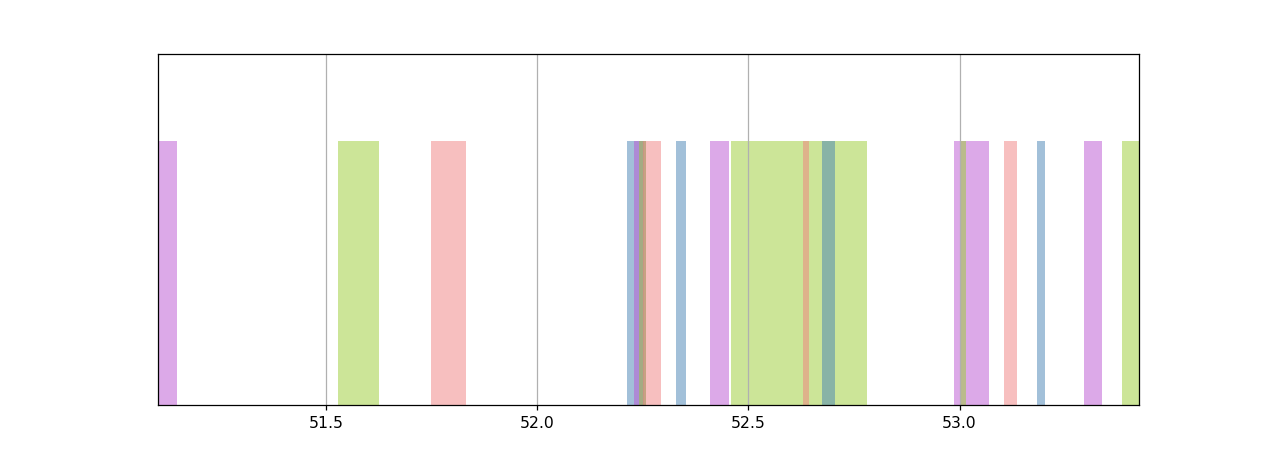

In [8]:
import matplotlib.pyplot as plt


def timeline_chart(result):
    max_iter_time = 0.0
    for host in result:
        max_iter_time = max(max_iter_time, host["avg_iter_time_ms"])

    bar_height_value = 0.3
    bar_height_increase_value = 0.5

    each_bar_height_inches = 0.4
    figure_width_inches = min(max_iter_time * 32 / 10, 10)

    y_label_font_size = 8
    color_options = ['steelblue', 'mediumorchid', 'yellowgreen', 'lightcoral']
    
    stream_num = 0
    fig, ax = plt.subplots()
    current_height = 0
    y_labels = []
    y_ticks = []
    all_bars = []
    current_height += bar_height_increase_value
    for host in result:
        for device_id, streams in host["timeline"].items():
            stream_num += len(streams)
            for stream_name, timeline in streams.items():
                event_timeline = []
                for event in timeline:
                    event_timeline.append([event["avg_iter_start_to_event_start_time_ms"], event["avg_measured_time_ms"]])
                bar = ax.broken_barh(event_timeline, [current_height, bar_height_value], facecolors=color_options, alpha=0.5)
                all_bars.append(bar)
                y_ticks.append(current_height + float(bar_height_value) / 2)
                y_labels.append(
                    host["host_name"] + '_'
                    + 'd' + device_id.split('_')[-1] + '_'
                    + 's' + stream_name.split('_')[-1])
                current_height += bar_height_increase_value

    y_ticks.append(current_height + float(bar_height_value) / 2)
    y_labels.append("Whole Iteration")
    ax.broken_barh([[0.0, max_iter_time]], [current_height, bar_height_value], facecolors=color_options, alpha=0.5)
    current_height += bar_height_increase_value
    fig.set_size_inches(figure_width_inches, each_bar_height_inches * (stream_num + 1))
    ax.set_xlim(0, max_iter_time)
    ax.grid(True)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontdict={ 'fontsize' : y_label_font_size })
    
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(bar):
        x = bar.get_x()+bar.get_width()/2.
        y = bar.get_y()+bar.get_height()
        annot.xy = (x,y)
        text = "({:.2g},{:.2g})".format( x,y )
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for bar in all_bars:
                cont, ind = bar.contains(event)
                if cont:
                    update_annot(bar)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    #fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.show()
        
timeline_chart(result)

<IPython.core.display.Javascript object>


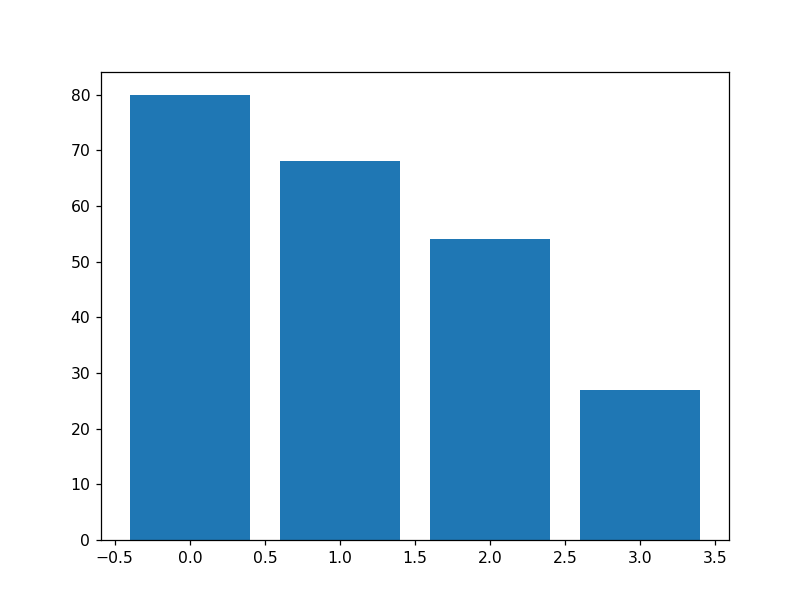

In [6]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

company=['google','amazon','msft','fb']
revenue=[80,68,54,27]

fig=plt.figure()
ax=plt.subplot()

xpos=np.arange(len(company))

bars = plt.bar(xpos,revenue)


annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(bar):
    x = bar.get_x()+bar.get_width()/2.
    y = bar.get_y()+bar.get_height()
    annot.xy = (x,y)
    text = "({:.2g},{:.2g})".format( x,y )
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for bar in bars:
            cont, ind = bar.contains(event)
            if cont:
                update_annot(bar)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()